Optimisation article 

Allows factoring other things in the optimisation - such as risk and trading costs

extra_dependencies = c("gmp", "Rmpfr", "ECOSolveR", "scs", "osqp", "RcppEigen")

In [1]:
# session  options
options(repr.plot.width = 14, repr.plot.height=7, warn = -1)

library(tidyverse)
library(tidyfit)
library(glue)
library(CVXR)
library(tibbletime)
library(roll)
library(patchwork)
pacman::p_load_current_gh("Robot-Wealth/rsims", dependencies = TRUE) 

# chart options
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'CVXR'


The following object is masked from 'package:dplyr':

    id


The following object is masked from 'package:purrr':

    is_vector


The following object is masked from 'package:stats':

    power



Attaching package: 'tibbletime'


The following object is masked from 'package:stats':

    filter




In [2]:
perps <- read_csv("https://github.com/Robot-Wealth/r-quant-recipes/raw/master/quantifying-combining-alphas/binance_perp_daily.csv")
head(perps)

Rows: 187251 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): ticker
dbl  (9): open, high, low, close, dollar_volume, num_trades, taker_buy_volum...
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ticker,date,open,high,low,close,dollar_volume,num_trades,taker_buy_volume,taker_buy_quote_volumne,funding_rate
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BTCUSDT,2019-09-11,10172.13,10293.11,9884.31,9991.84,85955369,10928,5169.153,52110075,-3e-04
BTCUSDT,2019-09-12,9992.18,10365.15,9934.11,10326.58,157223498,19384,11822.980,119810012,-3e-04
BTCUSDT,2019-09-13,10327.25,10450.13,10239.42,10296.57,189055129,25370,9198.551,94983470,-3e-04
BTCUSDT,2019-09-14,10294.81,10396.40,10153.51,10358.00,206031349,31494,9761.462,100482121,-3e-04
BTCUSDT,2019-09-15,10355.61,10419.97,10024.81,10306.37,211326874,27512,7418.716,76577710,-3e-04
BTCUSDT,2019-09-16,10306.79,10353.81,10115.00,10120.07,208211376,29030,7564.376,77673986,-3e-04


For the purposes of this example, we'll create the same crypto universe that we used last time - the top 30 Binance perpetual futures contracts by trailing 30-day dollar-volume, with stables and wrapped tokens removed. 

We'll also calculate returns at this step for later use. 

In [3]:
# get same universe as before - top 30 by rolling 30-day dollar volume, no stables

# remove stablecoins
# list of stablecoins from defi llama
url <- "https://stablecoins.llama.fi/stablecoins?includePrices=true"
response <- httr::GET(url)

stables <- response %>%
  httr::content(as = "text", encoding = "UTF-8") %>%
  jsonlite::fromJSON(flatten = TRUE) %>%
  pluck("peggedAssets") %>%
  pull(symbol)

# sort(stables)

perps <- perps %>% 
  filter(!ticker %in% glue::glue("{stables}USDT")) 

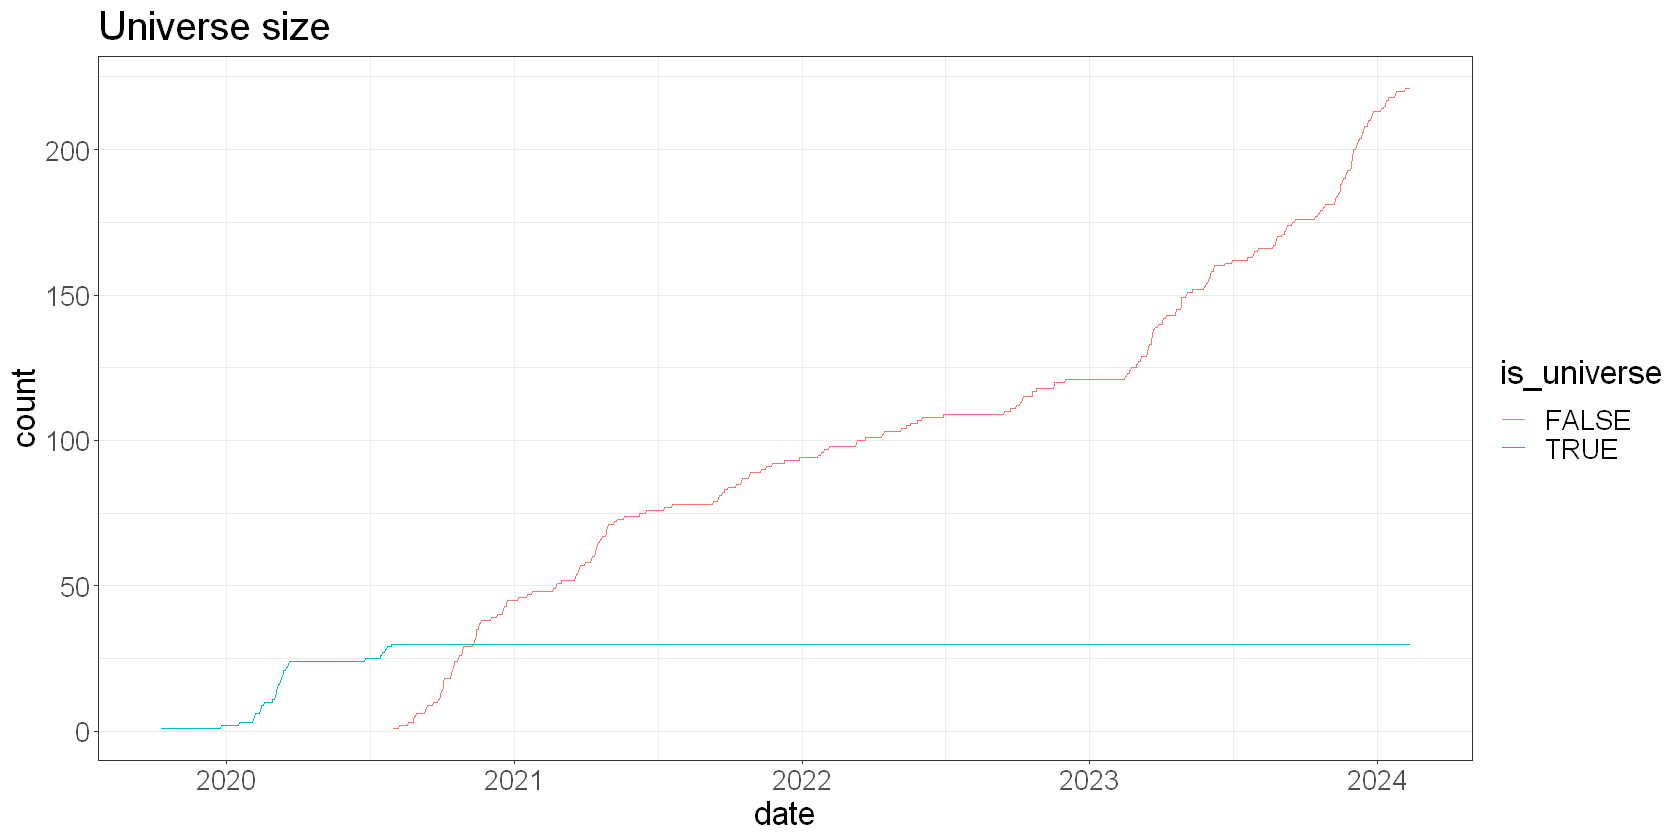

In [4]:
# get the top 30 by trailing 30-day volume
# exclude from universe until we have enough data to do a covariance estimate
trading_universe_size <- 30
ew_cov_init_wdw <- 30

universe <- perps %>%
  group_by(ticker) %>% 
  # also calculate returns for later
  mutate(
    total_return_simple = funding_rate + (close - lag(close, 1))/lag(close, 1),
    total_return_log = log(1 + total_return_simple),
    total_fwd_return_simple = dplyr::lead(funding_rate, 1) + (dplyr::lead(close, 1) - close)/close,
    total_fwd_return_log = log(1 + total_fwd_return_simple),
    trail_volume = roll_mean(dollar_volume, 30)
  ) %>% 
  mutate(days_since_listing = row_number()) %>%   # the number of days we have data for each ticker
  na.omit() %>%
  ungroup() %>% 
  # exclude from volume ranking - won't matter if we use a rolling volume calculated with more than the covariance initialisation window as will drop these rows using na.omit
  mutate(to_exclude = days_since_listing < ew_cov_init_wdw) %>%   
  group_by(date) %>%
  mutate(
    volume_rank = if_else(to_exclude, NA_integer_, row_number(-trail_volume)),
    is_universe = volume_rank <= trading_universe_size,
  ) 

universe %>%
  group_by(date, is_universe) %>%
  summarize(count = n(), .groups = "drop") %>%
  ggplot(aes(x=date, y=count, color = is_universe)) + 
  geom_line() + 
  labs(
    title = 'Universe size'
)

Next, calculate our features as before. We have:  
- Short-term (10-day) cross-sectional momentum (buckted into deciles by date)
- Short-term (1-day) cross-sectional carry (also bucketed into deciles by date)
- A breakout feature defined as the number of days since the 20-day high which we use as a time-series return predictor. 

In [5]:
# calculate features as before
rolling_days_since_high_20 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    }, 
    window = 20, na_value = NA), 
  otherwise = NA
)

features <- universe %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(
    breakout = 9.5 - rolling_days_since_high_20(close),  # puts this feature on a scale -9.5 to +9.5
    momo = close - lag(close, 10)/close,
    carry = funding_rate
  ) %>%
  ungroup() %>% 
  na.omit()

# create a model df on our universe with momo and carry features scaled into deciles
model_df <- features %>%
  filter(is_universe) %>% 
  group_by(date) %>%
  mutate(
    carry_decile = ntile(carry, 10),
    momo_decile = ntile(momo, 10),
    # also calculate demeaned return for everything in our universe each day for later
    demeaned_return = total_return_simple - mean(total_return_simple, na.rm = TRUE),
    demeaned_fwd_return = total_fwd_return_simple - mean(total_fwd_return_simple, na.rm = TRUE)
  ) %>% 
  ungroup()

  # start simulation from date we first have n tickers in the universe
start_date <- features %>%
  group_by(date, is_universe) %>%
  summarize(count = n(), .groups = "drop") %>%
  filter(count >= trading_universe_size) %>%
  head(1) %>%
  pull(date)

In [6]:
# use a 90-day window and refit every 10 days
is_days <- 90
step_size <- trading_universe_size*10  

# rolling model for cross-sectional features
roll_xs_coeffs_df <- model_df %>% 
  filter(date >= start_date) %>% 
  regress(
    demeaned_fwd_return ~ carry_decile + momo_decile,
    m("lm", vcov. = "HAC"),  
    .cv = "sliding_index", 
    .cv_args = list(lookback = days(is_days), step = step_size, index = "date"),  
    .force_cv = TRUE, 
    .return_slices = TRUE
  )

# rolling model for time series features 
breakout_cutoff <- 5.5  # below this level, we set our expected return to zero
roll_ts_coeffs_df <- model_df %>% 
  filter(date >= start_date) %>% 
  # setting regression weights to zero when breakout < breakout_cutoff will give these data points zero weight in estimating coefficients
  mutate(regression_weights = case_when(breakout < breakout_cutoff ~ 0, TRUE ~ 1)) %>% 
  regress(
    total_fwd_return_simple ~ breakout,
    m("lm", vcov. = "HAC"), 
    .weights = "regression_weights", 
    .cv = "sliding_index", 
    .cv_args = list(lookback = days(is_days), step = step_size, index = "date"),  
    .force_cv = TRUE, 
    .return_slices = TRUE
  )

This results in a nested dataframe that contains the model objects and various metadata:

In [7]:
roll_xs_coeffs_df %>% head
roll_ts_coeffs_df %>% select(-settings) %>% head

model,estimator_fct,size (MB),grid_id,model_object,settings,slice_id
<chr>,<chr>,<dbl>,<chr>,<list>,<list>,<chr>
lm,stats::lm,1.360960,#0010000,<environment: 0x00000169acab3ca0>,HAC,2021-02-11
lm,stats::lm,1.367016,#0010000,<environment: 0x00000169acd67438>,HAC,2021-02-21
lm,stats::lm,1.380032,#0010000,<environment: 0x00000169ad4de7e0>,HAC,2021-03-03
lm,stats::lm,1.384864,#0010000,<environment: 0x00000169ad683c50>,HAC,2021-03-13
lm,stats::lm,1.384808,#0010000,<environment: 0x00000169a525f2b8>,HAC,2021-03-23
lm,stats::lm,1.384944,#0010000,<environment: 0x00000169a336aa58>,HAC,2021-04-02


model,estimator_fct,size (MB),grid_id,model_object,slice_id
<chr>,<chr>,<dbl>,<chr>,<list>,<chr>
lm,stats::lm,1.245552,#0010000,<environment: 0x00000169a9cd1e70>,2021-02-11
lm,stats::lm,1.257864,#0010000,<environment: 0x00000169a9421110>,2021-02-21
lm,stats::lm,1.254896,#0010000,<environment: 0x00000169a64bc680>,2021-03-03
lm,stats::lm,1.255688,#0010000,<environment: 0x00000169a0435408>,2021-03-13
lm,stats::lm,1.260624,#0010000,<environment: 0x00000169a0147808>,2021-03-23
lm,stats::lm,1.257784,#0010000,<environment: 0x000001699f09fac0>,2021-04-02


`slice_id` is the date the model goes out of sample - so we'll need to make sure that we align our model coefficients to avoid using them on the data they were fitted on. 

This requires a little data wrangling:

In [8]:
# for this to work, need to install.packages("sandwich", "lmtest")
xs_coefs <- roll_xs_coeffs_df %>% 
  coef()

xs_coefs_df <- xs_coefs %>% 
  ungroup() %>% 
  select(term, estimate, slice_id) %>% 
  pivot_wider(id_cols = slice_id, names_from = term, values_from = estimate) %>% 
  mutate(slice_id = as_date(slice_id)) %>% 
  # need to lag slice id to make it oos
  # slice_id_oos is the date we start using the parameters
  mutate(slice_id_oos = lead(slice_id)) %>% 
  rename("xs_intercept" = `(Intercept)`)

ts_coefs <- roll_ts_coeffs_df %>% 
  coef()

ts_coefs_df <- ts_coefs %>% 
  ungroup() %>% 
  select(term, estimate, slice_id) %>% 
  pivot_wider(id_cols = slice_id, names_from = term, values_from = estimate) %>% 
  mutate(slice_id = as_date(slice_id)) %>% 
  # need to lag slice id to make it oos
  # slice_id_oos is the date we start using the parameters
  mutate(slice_id_oos = lead(slice_id)) %>% 
  rename("ts_intercept" = `(Intercept)`)

xs_coefs_df %>% head
# ts_coefs_df %>% head

Here's a plot of our cross-sectional features' regression coefficients through time:

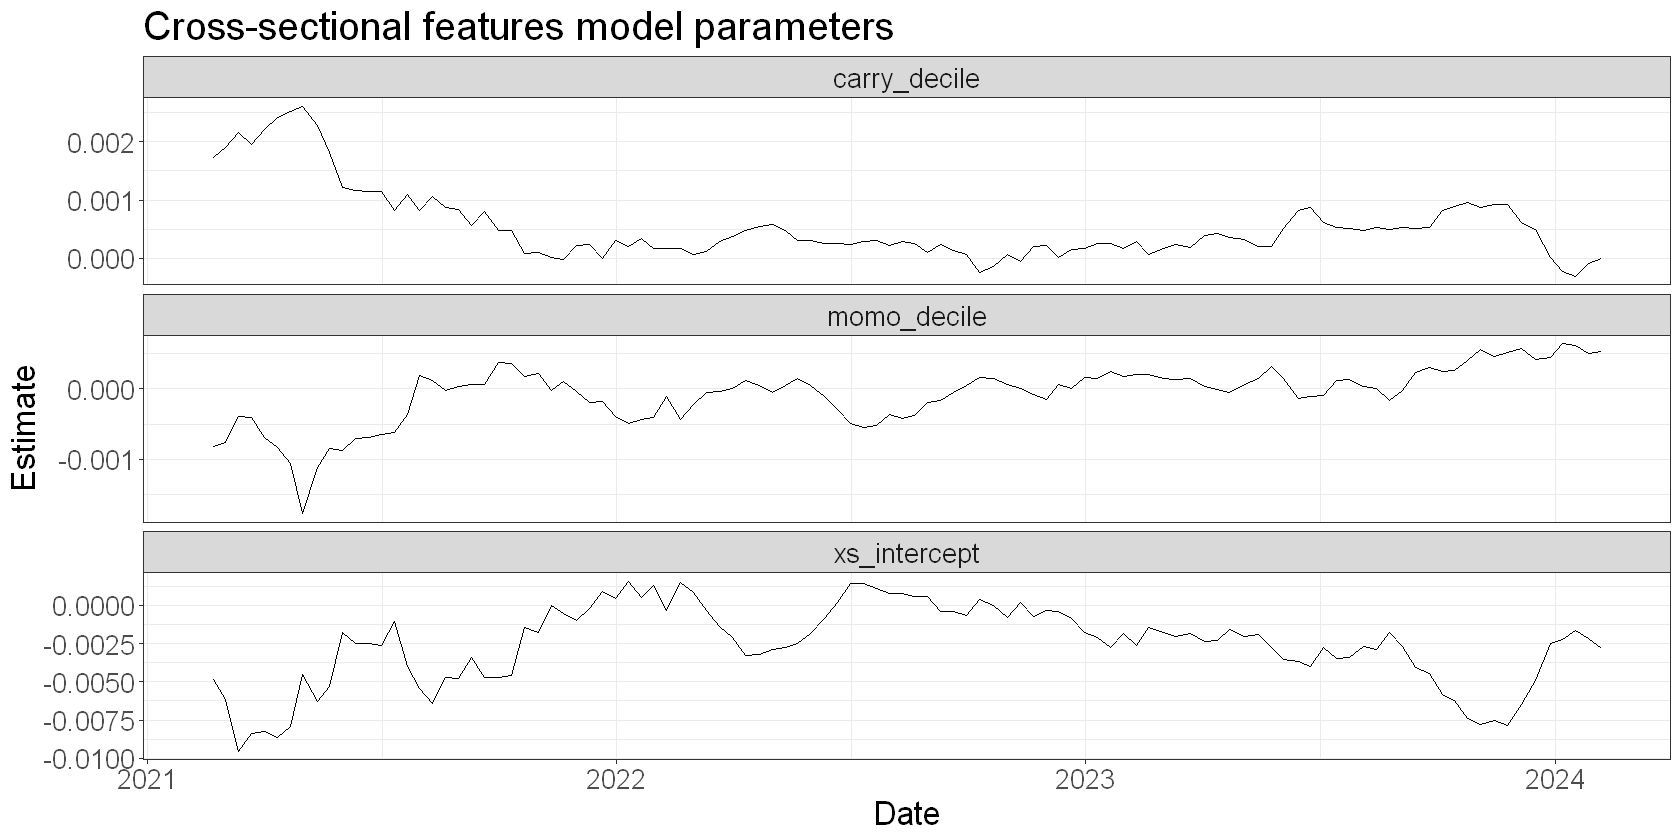

In [ ]:
# plot cross-sectional estimates
xs_coefs_df %>% 
  select(-slice_id) %>% 
  pivot_longer(cols = -slice_id_oos, names_to = "coefficient", values_to = "estimate") %>% 
  ggplot(aes(x = slice_id_oos, y = estimate)) +
  geom_line() +
  facet_wrap(~coefficient, ncol = 1, scales = "free_y") +
  labs(
    title = "Cross-sectional features model parameters",
    x = "Date",
    y = "Estimate"
  )

# plot time-series estimates
# ts_coefs_df %>% 
#   select(-slice_id) %>% 
#   pivot_longer(cols = -slice_id_oos, names_to = "coefficient", values_to = "estimate") %>% 
#   ggplot(aes(x = slice_id_oos, y = estimate)) +
#   geom_line() +
#   facet_wrap(~coefficient, ncol = 1, scales = "free_y") +
#   labs(
#     title = "Time-series features model parameters",
#     x = "Date",
#     y = "Estimate"
#   )

The estimates for the model coefficients for our carry and momentum features change over time to reflect the changing relationship with forward returns.  

In particular, notice how the momentum coefficient flipped sign a few times, but especially from mid-2022, which is in line with our understanding of how the feature evolved. 

Now we can plot a time series of returns to a frictionless trading strategy based on these expected return estimates. This isn't a backtest - it makes no attempt to address real-world issues such as costs and turnover. It simply plots the returns to our predictions of expected returns over time.

I won't actually use the linear model of the breakout feature - instead I'll just set its expected return to 0.002 when it's greater than 5 and 0 otherwise. I don't like that the breakout coefficients go negative from time to time.

I'll calculate target positions proportional to their cross-sectional return estimates. I'll then let the breakout feature tilt the portfolio net long, but I'll constrain the maximum delta that this feature can add to a position.

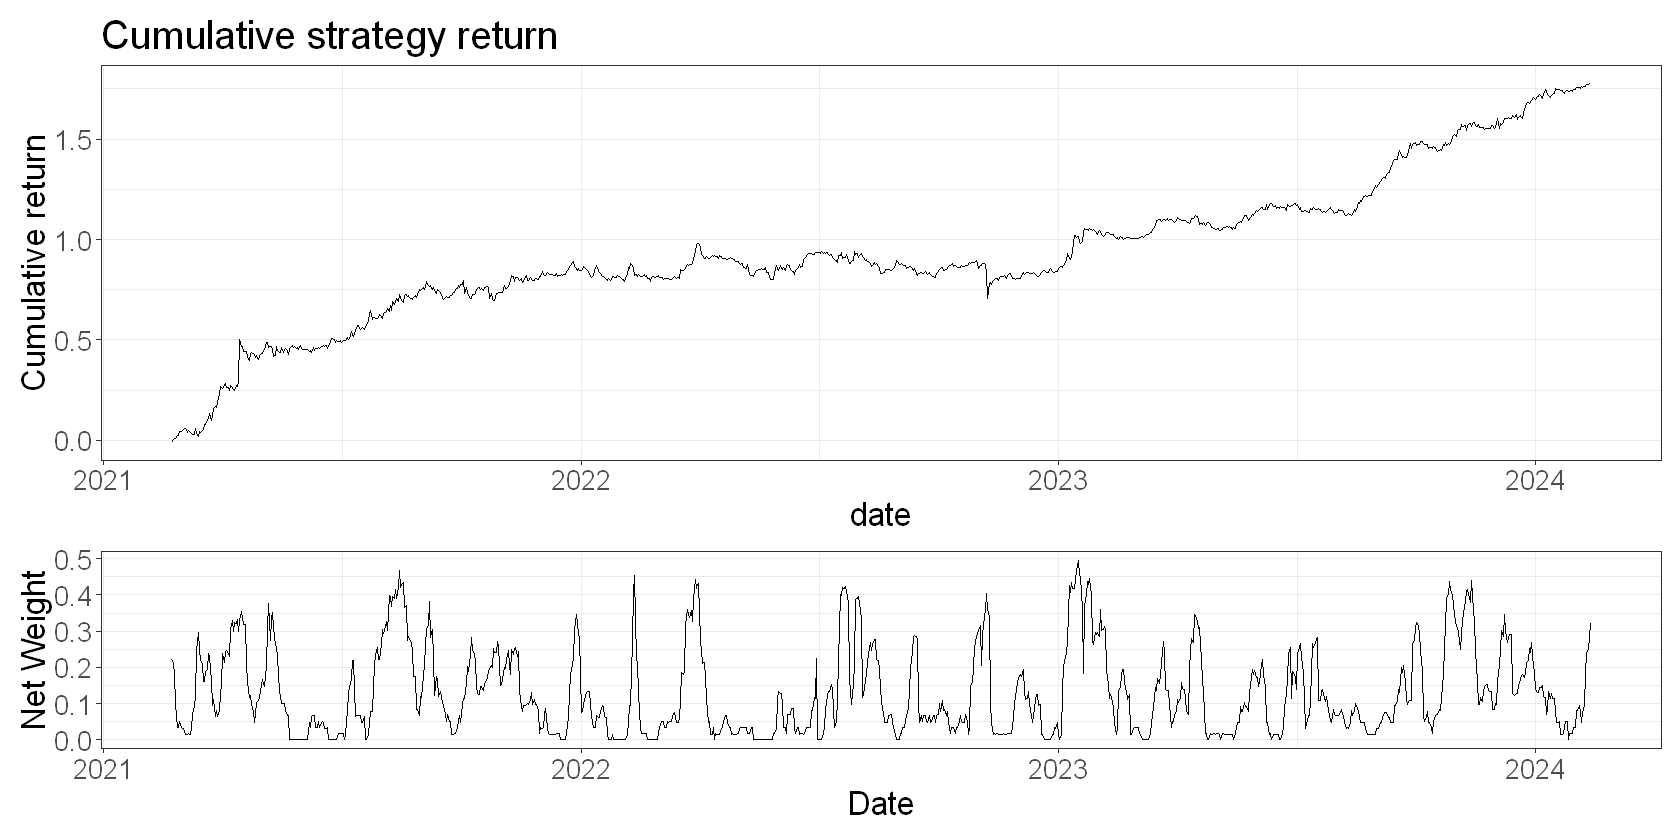

In [ ]:
# join and fill using slice_id to designate when the model goes oos
exp_return_df <- model_df %>% 
  left_join(
    xs_coefs_df %>% left_join(ts_coefs_df, by = c("slice_id", "slice_id_oos")), 
    by = join_by(closest(date > slice_id_oos)), suffix = c("_factor", "_coef")
  ) %>% 
  na.omit() %>% 
  # forecast cross-sectional expected return as
  mutate(expected_xs_return = carry_decile_factor*carry_decile_coef + momo_decile_factor*momo_decile_coef + xs_intercept ) %>% 
  # mean expected xs return each day is zero
  # let total expected return be xs return + ts return - allows time series expected return to tilt weights
  mutate(expected_ts_return = case_when(breakout_factor >= 5.5 ~ 0.002, TRUE ~ 0)) %>% 
  ungroup() 

# long-short the xs expected return
# layer ts expected return on top
# position by expected return

# 1 in the numerator lets it get max 100% long due to breakout
max_ts_pos <- 0.5/trading_universe_size

strategy_df <- exp_return_df %>% 
  filter(date >= start_date) %>% 
  group_by(date) %>% 
  mutate(xs_position = expected_xs_return - mean(expected_xs_return, na.rm = TRUE)) %>% 
  # scale positions so that leverage is 1
  group_by(date) %>% 
  mutate(xs_position = if_else(xs_position == 0, 0, xs_position/sum(abs(xs_position)))) %>%
  # layer ts expected return prediction
  ungroup() %>% 
  mutate(ts_position = sign(expected_ts_return)) %>% 
  # constrain maximum delta added by time series prediction
  mutate(ts_position = if_else(ts_position >= 0, pmin(ts_position, max_ts_pos), pmax(ts_position, -max_ts_pos))) %>% 
  mutate(position = xs_position + ts_position) %>% 
  # strategy return
  mutate(strat_return = position*total_fwd_return_simple) %>% 
  # scale back to leverage 1
  group_by(date) %>% 
  mutate(position = if_else(position == 0, 0, position/sum(abs(position)))) 
  
returns_plot <- strategy_df %>%
  group_by(date) %>% 
  summarise(total_ret = sum(strat_return)) %>% 
  ggplot(aes(x = date, y = cumsum(log(1+total_ret)))) +
  geom_line() +
  labs(
    title = "Cumulative strategy return",
    y = "Cumulative return"
  )

weights_plot <- strategy_df %>%
  summarise(net_pos = sum(position)) %>% 
  ggplot(aes(x = date, y = net_pos)) +
  geom_line() +
  labs(
    x = "Date",
    y = "Net Weight"
  )

returns_plot / weights_plot + plot_layout(heights = c(2,1))

In [ ]:
# tickers that were ever in the universe
universe_tickers <- features %>%
  filter(is_universe) %>%
  pull(ticker) %>%
  unique()

universe_tickers

[1] "BTCUSDT"      "ETHUSDT"      "BCHUSDT"      "XRPUSDT"      "EOSUSDT"     
  [6] "LTCUSDT"      "TRXUSDT"      "ETCUSDT"      "LINKUSDT"     "XLMUSDT"     
 [11] "ADAUSDT"      "XMRUSDT"      "DASHUSDT"     "ZECUSDT"      "XTZUSDT"     
 [16] "ATOMUSDT"     "BNBUSDT"      "ONTUSDT"      "IOTAUSDT"     "BATUSDT"     
 [21] "VETUSDT"      "NEOUSDT"      "QTUMUSDT"     "IOSTUSDT"     "THETAUSDT"   
 [26] "ALGOUSDT"     "ZILUSDT"      "KNCUSDT"      "ZRXUSDT"      "COMPUSDT"    
 [31] "OMGUSDT"      "SXPUSDT"      "KAVAUSDT"     "BANDUSDT"     "RLCUSDT"     
 [36] "WAVESUSDT"    "DOTUSDT"      "MKRUSDT"      "YFIUSDT"      "CRVUSDT"     
 [41] "SUSHIUSDT"    "TRBUSDT"      "UNIUSDT"      "SOLUSDT"      "AVAXUSDT"    
 [46] "AAVEUSDT"     "FILUSDT"      "RSRUSDT"      "EGLDUSDT"     "SNXUSDT"     
 [51] "DOGEUSDT"     "ALPHAUSDT"    "GRTUSDT"      "1INCHUSDT"    "FTMUSDT"     
 [56] "ENJUSDT"      "CHZUSDT"      "MATICUSDT"    "ANKRUSDT"     "STORJUSDT"   
 [61] "SKLUSDT"      "KSMUSDT"      "RUNEUSDT"     "1000SHIBUSDT" "AXSUSDT"     
 [66] "SANDUSDT"     "ALICEUSDT"    "CHRUSDT"      "BAKEUSDT"     "DENTUSDT"    
 [71] "SRMUSDT"      "NEARUSDT"     "CELRUSDT"     "COTIUSDT"     "ONEUSDT"     
 [76] "SFPUSDT"      "DYDXUSDT"     "MANAUSDT"     "LRCUSDT"      "IOTXUSDT"    
 [81] "GALAUSDT"     "GTCUSDT"      "PEOPLEUSDT"   "OGNUSDT"      "IMXUSDT"     
 [86] "MTLUSDT"      "GMTUSDT"      "ENSUSDT"      "APEUSDT"      "BELUSDT"     
 [91] "UNFIUSDT"     "FLMUSDT"      "LITUSDT"      "OPUSDT"       "FLOWUSDT"    
 [96] "BLZUSDT"      "HNTUSDT"      "RVNUSDT"      "REEFUSDT"     "1000LUNCUSDT"
[101] "KLAYUSDT"     "LUNA2USDT"    "MASKUSDT"     "FTTUSDT"      "APTUSDT"     
[106] "RENUSDT"      "OCEANUSDT"    "LDOUSDT"      "FETUSDT"      "MAGICUSDT"   
[111] "AGIXUSDT"     "LINAUSDT"     "CFXUSDT"      "STXUSDT"      "INJUSDT"     
[116] "ICXUSDT"      "CTSIUSDT"     "RNDRUSDT"     "COCOSUSDT"    "TOMOUSDT"    
[121] "ARBUSDT"      "IDUSDT"       "ARPAUSDT"     "EDUUSDT"      "SUIUSDT"     
[126] "1000PEPEUSDT" "1000XECUSDT"  "STMXUSDT"     "LPTUSDT"      "C98USDT"     
[131] "HBARUSDT"     "API3USDT"     "PERPUSDT"     "NMRUSDT"      "WLDUSDT"     
[136] "LEVERUSDT"    "CYBERUSDT"    "BNTUSDT"      "LQTYUSDT"     "MINAUSDT"    
[141] "ARKUSDT"      "BLURUSDT"     "SEIUSDT"      "BIGTIMEUSDT"  "GASUSDT"     
[146] "TIAUSDT"      "MEMEUSDT"     "ORDIUSDT"     "ICPUSDT"      "1000BONKUSDT"
[151] "UMAUSDT"      "POWRUSDT"     "1000SATSUSDT" "PYTHUSDT"

In [ ]:
strategy_df <- exp_return_df %>% 
  filter(date >= start_date) %>% 
  group_by(date) %>% 
  mutate(expected_xs_return = expected_xs_return - mean(expected_xs_return, na.rm = TRUE)) %>% 
  ungroup() %>% 
  mutate(expected_return = expected_xs_return + expected_ts_return) %>% 
  select(date, ticker, expected_return) %>% 
  # join back onto df of prices for all tickers that were ever in the universe
  # so that we have prices before and after a ticker comes into or out of the universe
  # for backtesting purposes
  right_join(
    features %>% 
      filter(ticker %in% universe_tickers) %>% 
      select(date, ticker, close, total_fwd_return_simple, funding_rate), 
    by = c("date", "ticker")
  ) %>% 
  # give anything with a NA weight (due to the join) a zero... or do we want to keep this as NA?
  # replace_na(list(expected_return = 0)) %>%
  arrange(date, ticker) %>%
  filter(date >= start_date)

In [ ]:
# get same length exp returns vector for each date
exp_returns_wide <- strategy_df %>% 
  select(ticker, date, expected_return) %>% 
  # will give NA where a ticker didn't exist
  pivot_wider(id_cols = date, names_from = ticker, values_from = expected_return)

In [18]:
# covariances
# this is an in-sample covariance matrix for everything
sigma <- features %>% 
  filter(ticker %in% universe_tickers) %>% 
  select(ticker, date, total_return_simple) %>% 
  pivot_wider(id_cols = date, names_from = ticker, values_from = total_return_simple) %>% 
  filter(date >= start_date) %>% 
  # some rows will have NA due to date things came into existence. probably just use pairwise.complete.obs
  # although this can result in matrixes that aren't PSD 
  select(-date) %>% 
  cov(use = "pairwise.complete.obs")

head(sigma)

,BTCUSDT,ETHUSDT,BCHUSDT,XRPUSDT,EOSUSDT,LTCUSDT,TRXUSDT,ETCUSDT,LINKUSDT,XLMUSDT,⋯,ARKUSDT,BIGTIMEUSDT,GASUSDT,POWRUSDT,TIAUSDT,MEMEUSDT,ORDIUSDT,1000BONKUSDT,PYTHUSDT,1000SATSUSDT
BTCUSDT,0.001257750,0.001265187,0.001292076,0.001115746,0.001228519,0.001374415,0.0009567806,0.001278436,0.001349403,0.001187751,⋯,0.0004572614,0.0008971800,0.0003884761,7.137973e-05,0.0007968656,0.0006152759,0.0007570901,0.0013995239,0.0003881934,3.737449e-04
ETHUSDT,0.001265187,0.001894860,0.001601769,0.001455268,0.001586128,0.001714758,0.0011794332,0.001841863,0.001921484,0.001563655,⋯,0.0007247233,0.0007315801,0.0006155184,-3.249583e-05,0.0002907538,0.0008001309,0.0005765096,0.0009809659,0.0003911769,3.025503e-04
BCHUSDT,0.001292076,0.001601769,0.002517979,0.001650154,0.001876128,0.001926555,0.0013091551,0.002313368,0.001898103,0.001808057,⋯,0.0004925287,0.0011506410,0.0004856916,3.387579e-04,0.0003967369,0.0009569715,0.0008240247,0.0018537774,0.0007740062,-6.085514e-05
XRPUSDT,0.001115746,0.001455268,0.001650154,0.003351683,0.001882594,0.001689355,0.0014283803,0.001824146,0.001845807,0.002317943,⋯,0.0004762300,0.0006059839,0.0005503228,-9.190736e-05,0.0005900446,0.0008936143,0.0006949940,0.0010784931,0.0006377378,2.433058e-05
EOSUSDT,0.001228519,0.001586128,0.001876128,0.001882594,0.002665066,0.001889743,0.0015077323,0.002185584,0.002022431,0.001988568,⋯,0.0007372026,0.0013071906,0.0008202318,-2.254763e-04,0.0005419884,0.0011924345,0.0011503750,0.0013801471,0.0008974178,5.859936e-05
LTCUSDT,0.001374415,0.001714758,0.001926555,0.001689355,0.001889743,0.002456971,0.0013433160,0.002046660,0.002036484,0.001788308,⋯,0.0005532189,0.0006777831,0.0006348186,-2.362741e-04,0.0002527921,0.0008244184,0.0004917830,0.0008205351,0.0005166350,-2.901757e-05


In [19]:
library(Matrix)
library(matrixcalc)

is.positive.semi.definite(sigma, tol=1e-8)
isSymmetric(sigma)


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack



Attaching package: 'matrixcalc'


The following object is masked from 'package:CVXR':

    vec




[1] FALSE

[1] TRUE

In [20]:
# if we make our covariance matrix from different number of pairwise obs, can be not PSD. Force it to be:
sigma_pd <- nearPD(sigma)
sigma_pd <- sigma_pd$mat

is.positive.semi.definite(as.matrix(sigma_pd), tol=1e-8)

[1] TRUE

In [21]:
mvo_with_costs <- function(expected_returns, current_weights, na_idxs = c(), costs, covmat, lambda = 1, tau=1) {
  # define our weights vector as a CVXR::Variable
  weights <- Variable(length(expected_returns))
  # define an alpha term as the weighted sum of expected returns
    # again, express using linear algebra
  alpha_term <- (t(weights) %*% expected_returns)
  # define a costs term. depends on:
    # cost of trading - needs to be expressed such that it scales with expected returns
      # calculate as elementwise cost * absolute value of weights - current_weights
      # use CVXR::multiply and CVXR::abs
    # absolute distance of current_weights to our weights variable
      # the more our target weights differ from current weights, the more it costs to trade
      # this is a decent representation of fixed percentage costs, but doesn't capture minimum commissions
    # sum_entries is a CVXR function for summing the elements of a vector
  costs_term <- sum_entries(multiply(costs, abs(weights - current_weights))) # elementwise abs, multiply
  # define a risk term as w*Sigma*w
    # quad_form is a CVXR function for doing w*Sigma*w
  risk_term <- quad_form(weights, covmat)
  # define our objective
    # maximise our alpha less our risk term multiplied by some factor, lambda, less our costs term multiplied by tau
  objective <- Maximize(alpha_term - lambda*risk_term - tau*costs_term)
  # apply our no leverage constraint
  constraints <- list(cvxr_norm(weights, 1) <= 1, weights[na_idxs] == 0)
  # specify the problem
  problem <- Problem(objective, constraints)
  # solve
  result <- solve(problem)

  # return the values of the variable we solved for
  result$getValue(weights)
}

In [22]:
# # expected returns in same order as columns of covariance matrix
# # actually don't want to have tickers not in today's universe here... how to manage this when something drops out of the universe? constraints? YES
# weights <- list()
# w0 <- rep(0, ncol(sigma_pd))
# i <- 1
# for( d in exp_returns_wide$date ) {
#     # get row of expected returns as a vector in the same order as the columns of the covariance matrix
#     # contains NA at this point
#     exp_rets <- exp_returns_wide %>% filter(date == d) %>% pivot_longer(-date, names_to = "ticker", values_to = "expected_return")%>% arrange(match(ticker, colnames(sigma))) %>% pull(expected_return)
#     # get na indexes
#     # we'll explicitly constrain these to get zero weight
#     na_idxs <- which(is.na(exp_rets))
#     # convert NA to zero
#     exp_rets[is.na(exp_rets)] <- 0
#     w <- mvo_with_costs(expected_returns = exp_rets, current_weights = w0, na_idxs = na_idxs, costs = 5./10000, covmat = sigma_pd, lambda = 10, tau=5)
#     # w is a one-column matrix
#     weights[[i]] <- w
#     i <- i+1
#     w0 <- w 
# }

In [ ]:
weights_mat_to_df <- function(x, d, tickers) {
  x %>% 
    as_tibble(.name_repair = ~"weight") %>% 
    mutate(date = d) %>% mutate(ticker = tickers)
}

In [ ]:
weights_df <- purrr::map2(weights, exp_returns_wide$date, ~weights_mat_to_df(.x, .y, tickers = colnames(sigma_pd))) %>% 
  bind_rows()

In [ ]:
weights_df %>% 
  left_join(strategy_df, by = c("ticker", "date")) %>% 
  mutate(strat_return = weight * total_fwd_return_simple) %>% 
  replace_na(list(strat_return = 0)) %>% 
  group_by(date) %>% 
  summarise(port_return = sum(strat_return), .groups = "drop") %>% 
  mutate(port_return_log = log(1 + port_return)) %>% 
  mutate(cum_return = cumsum(port_return_log)) %>% 
  ggplot(aes(x = date, y = cum_return)) + geom_line()

^^^ in-sample cov mat

In [ ]:
strategy_df %>% head

How to manage covariances on a rolling basis??

At each iteration, need to get the covariance matrix for all the assets that:
- You have a current position in
- You have a non-NA expected return for

Could set up by having an exponentially weighted covariance matrix for everything, then constructing the matrix from the assets under consideration at that iteration.

There's an EWMA covariance estimate on the blog. 

Need to use try_catch on the solver

<!-- tau < 10
lambda 1-20? -->

In [23]:
# EWMA covariance estimate
# note definition of lambda in line with Risk Metrics
# ie higher values of lambda put less weight on the most recent returns and more weight on historical returns.
ewma_cov <- function(x, y, lambda, initialisation_wdw = 100) {
  # check that x and y are the same length and greater than initialisation_wdw
  stopifnot("x and y must be of equal length" = length(x) == length(y))
  if(length(x) <= initialisation_wdw) {
    ewma_cov <- rep(NA, length(x))
    return(ewma_cov)
  }

  # create initialisation window and estimation window
  init_x = x[1:initialisation_wdw]
  init_y = y[1:initialisation_wdw]

  num_obs <- length(x)

  # initial covariance and mean return estimates
  old_cov <- cov(init_x, init_y)
  old_x <- mean(init_x)
  old_y <- mean(init_y)

  # preallocate output vector
  ewma_cov <- vector(mode = "numeric", length = num_obs)

  # pad with NA for initialisation window
  ewma_cov[1:initialisation_wdw] <- NA

  # covariance estimate
  for(i in c((initialisation_wdw+1):num_obs)) {
    ewma_cov[i] <- lambda*old_cov + (1 - lambda)*(old_x * old_y)
    old_cov <- ewma_cov[i]
    old_x <- x[i]
    old_y <- y[i]
  }
  ewma_cov
}

In [24]:
lambda <- 0.995
wdw <- ew_cov_init_wdw

returns <- features %>% 
  filter(ticker %in% universe_tickers) %>% 
  select(ticker, date, total_return_simple)

ewma_covs <- returns %>%
  full_join(returns, by = "date") %>%
  na.omit() %>%
  ungroup() %>%
  # drop diagonal
  # dplyr::filter(ticker.x != ticker.y) %>%
  # get all combinations (tickers) and remove duplicate combos (eg BTC-ETH, ETH-BTC)
  mutate(tickers = ifelse(ticker.x < ticker.y, glue("{ticker.x}, {ticker.y}"), glue("{ticker.y}, {ticker.x}"))) %>%
  distinct(date, tickers, .keep_all = TRUE) %>%
  # calculate rolling pairwise ewma correlations
  group_by(tickers) %>%
  arrange(date, .by_group = TRUE) %>%
  mutate(ewma_cov = ewma_cov(total_return_simple.x, total_return_simple.y, lambda = lambda, initialisation_wdw = ew_cov_init_wdw)) %>%
  select(date, tickers, ewma_cov, ticker.x, ticker.y) %>%
  na.omit() %>% 
  ungroup()

tail(ewma_covs)

date,tickers,ewma_cov,ticker.x,ticker.y
<date>,<chr>,<dbl>,<chr>,<chr>
2024-02-07,"ZRXUSDT, ZRXUSDT",0.003337849,ZRXUSDT,ZRXUSDT
2024-02-08,"ZRXUSDT, ZRXUSDT",0.003321164,ZRXUSDT,ZRXUSDT
2024-02-09,"ZRXUSDT, ZRXUSDT",0.003306101,ZRXUSDT,ZRXUSDT
2024-02-10,"ZRXUSDT, ZRXUSDT",0.003290074,ZRXUSDT,ZRXUSDT
2024-02-11,"ZRXUSDT, ZRXUSDT",0.003274115,ZRXUSDT,ZRXUSDT
2024-02-12,"ZRXUSDT, ZRXUSDT",0.003259633,ZRXUSDT,ZRXUSDT


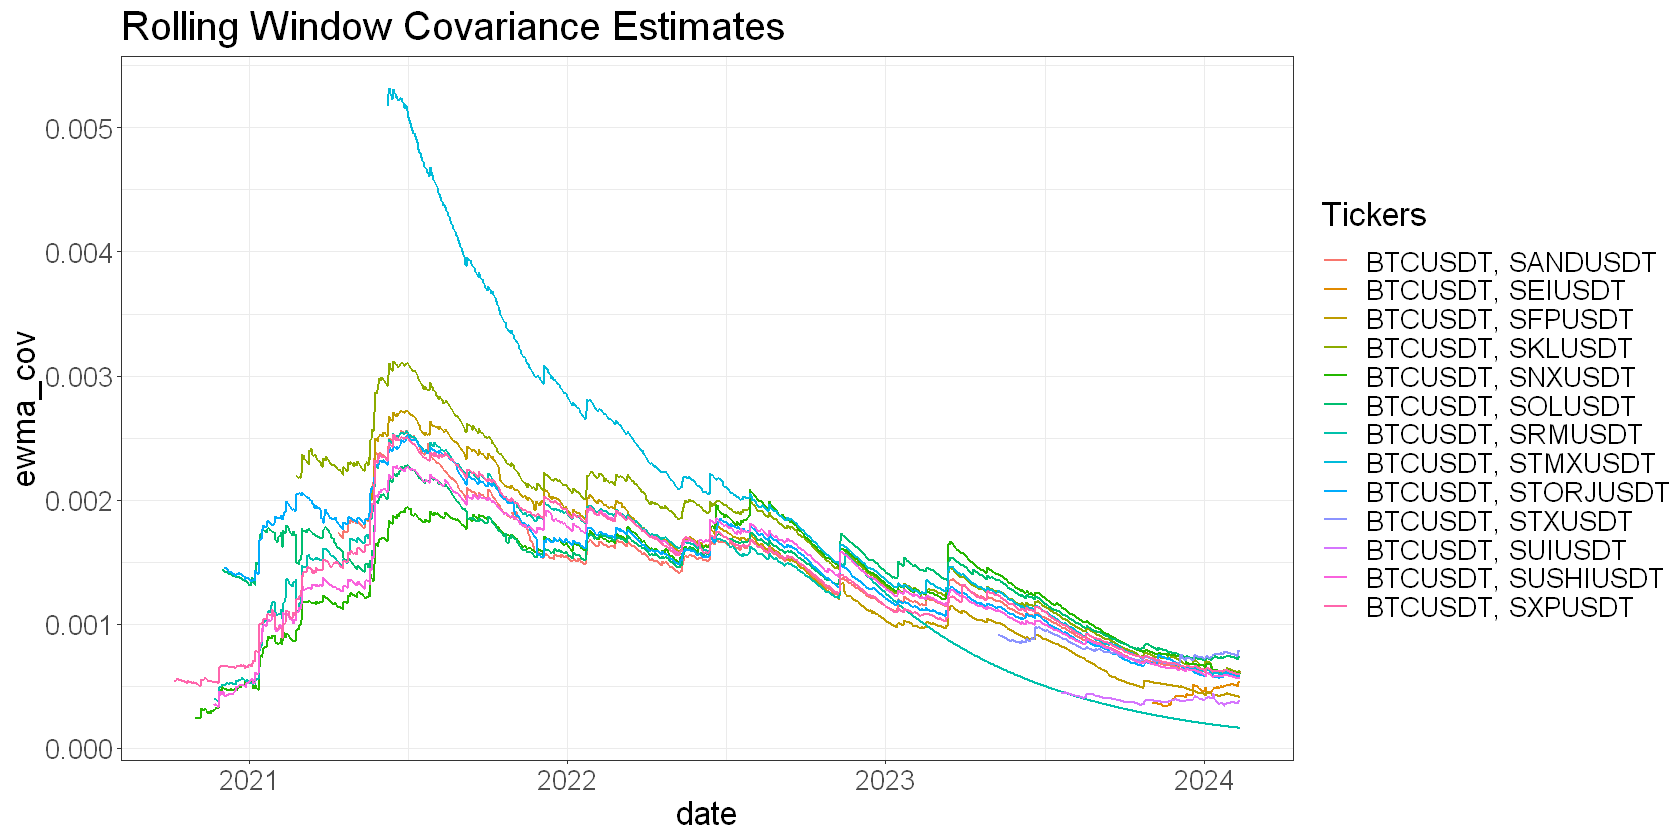

In [25]:
# plot pairwise rolling covariances
ewma_covs %>%
  filter(str_starts(tickers, "BTCUSDT, S")) %>%
  ggplot(aes(x = date, y = ewma_cov, colour = tickers)) +
    geom_line(size=0.8) +
    # facet_wrap(~Tickers, ncol = 1) +
    labs(
      title = "Rolling Window Covariance Estimates",
      colour = "Tickers"
    )

In [26]:
# # recover and shrink covariance matrix for a given day
# # function for recovering daily covmat from long covariance dataframe
# recover_covmat <- function(long_covs, tickers, num_assets) {
#   cov_mat <- matrix(rep(0, num_assets*num_assets), num_assets)
#   dimnames(cov_mat) <- list(tickers, tickers)

#   # recover lower triangle and diagonal
#   cov_mat[lower.tri(cov_mat, diag = TRUE)] <- long_covs$ewma_cov

#   # recover upper triangle as upper triangle of transpose of half-formed matrix
#   cov_mat[upper.tri(cov_mat)] <- t(cov_mat)[upper.tri(cov_mat)]

#   cov_mat
# }

In [27]:
today_cov_df <- ewma_covs %>%
  ungroup() %>% 
  filter(date == "2024-02-02") %>% 
  select(ticker.x, ticker.y, ewma_cov) %>%
  pivot_wider(names_from = ticker.y, values_from = ewma_cov) %>%  # , names_prefix = "cov_"
  column_to_rownames(var = "ticker.x")

# check rownames and colnames match
all.equal(rownames(today_cov_df), colnames(today_cov_df))

[1] TRUE

In [28]:
today_covmat <- as.matrix(today_cov_df)
today_covmat[lower.tri(today_covmat)] <- t(today_covmat)[lower.tri(today_covmat)]

is.positive.semi.definite(today_covmat, tol=1e-8)
isSymmetric(today_covmat)

[1] FALSE

[1] TRUE

In [29]:
# if we make our covariance matrix from different number of pairwise obs, can be not PSD. Force it to be:
today_covmat_pd <- nearPD(today_covmat)$mat
# today_covmat_pd <- today_covmat_pd$mat

is.positive.semi.definite(as.matrix(today_covmat_pd), tol=1e-8)

[1] TRUE

In [30]:
# shrink covmat
# library(corpcor)

# cov.shrink works on returns data - maybe could compute for a rolling window?
# today_covmat_shrunk <- cov.shrink()


In [31]:
# Assuming 'cov_matrix' is your pre-computed covariance matrix

# Calculate the average variance from the diagonal of the covariance matrix
average_variance <- mean(diag(today_covmat_pd))

# Define the shrinkage target matrix (e.g., identity matrix scaled by average variance)
target_matrix <- diag(average_variance, nrow = ncol(today_covmat_pd))

# Define the shrinkage intensity (lambda) - choose a value between 0 and 1
# 0 means no shrinkage (use the original cov_matrix),
# 1 means full shrinkage (use only the target_matrix)
lambda <- 0.9

# Compute the shrunk covariance matrix
today_covmat_shrunk <- (1 - lambda) * today_covmat_pd + lambda * target_matrix
# note shrinks covs towards zero, reflecting uncertainty in cov estimates. may increases variances

In [32]:
i <- 3
j <- 4
today_covmat[i, j]
today_covmat_shrunk[i, j]

[1] 0.0007312895

[1] 7.370755e-05

Next steps:
- Compare shrunk and unshrunk covars for a few days to the in-sample covariances. Want to generally shrink towards those values. See if this is actually the case. 

In clude comments about stickiness of covariance estimates - should test this assumption (but probably holds in a very noisy way - hence we shrink.)

In [37]:
# difs <- vector()
# for( a1 in asset_names ) {
#     for (a2 in asset_names ) {
#         if(a1 %in% colnames(today_covmat_shrunk) & a2 %in% colnames(today_covmat_shrunk)) {
#             dif <- (sigma_pd[a1, a2] - today_covmat_shrunk[a1, a2])/sigma_pd[a1, a2]
#             difs <- c(difs, dif)
#             # shrunk value is bigger than original value
#             if(dif < -1)
#               cat(a1, a2, sigma_pd[a1, a2], today_covmat_shrunk[a1, a2], "\n")
#         }
#     }
# }

# data.frame(difs = difs, idx = c(1:length(difs))) %>% ggplot(aes(x = idx, y = difs)) + geom_line()

In [ ]:
# need a covariance estimate
# start with in-sample covariance to prove it works, then calculate on a rolling basis, with shrinkage
# maybe do the constrained downside example as well

Other things you can do - different model types, (lasso, ridge), more stable features - 3-day crypto funding, 20-day momentum.... other signals, etc


In [74]:
# functions for wrangling covariance matrix

get_today_covmat <- function(ewma_covs_long, today_date) {
    today_cov_df <- ewma_covs_long %>%
        ungroup() %>% 
        filter(date == today_date) %>% 
        select(ticker.x, ticker.y, ewma_cov) %>%
        pivot_wider(names_from = ticker.y, values_from = ewma_cov) %>%  # , names_prefix = "cov_"
        column_to_rownames(var = "ticker.x")
    
    # check rownames and colnames match
    stopifnot("error making today's cov matrix" = all.equal(rownames(today_cov_df), colnames(today_cov_df)))
    today_covmat <- as.matrix(today_cov_df)
    today_covmat[lower.tri(today_covmat)] <- t(today_covmat)[lower.tri(today_covmat)]
    
    # return nearest positive semi-definite matrix
    today_covmat <- nearPD(today_covmat)
    return(today_covmat$mat)
}

#' shrinks covs towards zero, reflecting uncertainty in cov estimates. may increases variances.
#' @param shrinkage_intensity: a value between 0 and 1. 0 means no shrinkage (use the original covmat), 1 means full shrinkage (use only the target_matrix)
shrink_covmat <- function(covmat, shrinkage_intensity = 0.9) {
    # average variance from the diagonal 
    average_variance <- mean(diag(covmat))
    # shrinkage target matrix (identity matrix scaled by average variance)
    target_matrix <- diag(average_variance, nrow = ncol(covmat))
    # shrunk covariance matrix
    covmat_shrunk <- (1 - shrinkage_intensity) * covmat + shrinkage_intensity * target_matrix

    return(covmat_shrunk)
}

#' extend covmat to cover all tickers in the tradeable universe
#' put average variance on the diagonal, zeroes elsewhere
#' intent is that optimisation will explicitly constrain weights for assets not yet in the universe to 0
extend_covmat <- function(covmat, all_tickers) {
    current_tickers <- colnames(covmat) 
    
    full_covmat <- matrix(0, nrow = length(all_tickers), ncol = length(all_tickers),
         dimnames = list(all_tickers, all_tickers))
    
    current_tickers_ordered <- intersect(all_tickers, rownames(covmat))

    # ensure covmats are ordered correctly
    covmat_reordered <- covmat[current_tickers_ordered, current_tickers_ordered] %>% 
      # ensure is Matrix type for compatibility
      as.matrix()
    full_covmat <- full_covmat[all_tickers, all_tickers]

    # replace in full_covmat
    full_covmat[current_tickers_ordered, current_tickers_ordered] <- covmat_reordered

    # replace zeros on diagonal with average variance
    zero_diag_indices <- which(diag(full_covmat) == 0)
    average_variance <- mean(diag(covmat))
    diag(full_covmat)[zero_diag_indices] <- average_variance
    
    return(full_covmat)
}

wrangle_covmat <- function(ewma_covs_long, date, tickers, shrinkage_intensity = 0.9) {
    today_covmat <- get_today_covmat(ewma_covs_long, date) %>% 
      shrink_covmat(shrinkage_intensity = shrinkage_intensity) %>% 
      extend_covmat(all_tickers = tickers)

    # check
    if(is.positive.semi.definite(today_covmat, tol=1e-8)){
        if(isSymmetric(today_covmat)) {
            glue("covmat crated for {date} not symmetric")
        }
    } else {
        glue("covmat crated for {date} not PSD")
    }    
    
    return(today_covmat)
}

In [75]:
today_covmat <- get_today_covmat(ewma_covs, dates[1]) %>% 
      shrink_covmat(shrinkage_intensity = 0.9) %>% 
      extend_covmat(all_tickers = universe_tickers)

In [76]:
is.positive.semi.definite(today_covmat, tol=1e-8)

[1] TRUE

In [77]:
today_covmat %>% head

,BTCUSDT,ETHUSDT,BCHUSDT,XRPUSDT,EOSUSDT,LTCUSDT,TRXUSDT,ETCUSDT,LINKUSDT,XLMUSDT,⋯,GASUSDT,TIAUSDT,MEMEUSDT,ORDIUSDT,ICPUSDT,1000BONKUSDT,UMAUSDT,POWRUSDT,1000SATSUSDT,PYTHUSDT
BTCUSDT,0.0073908929,0.0001752296,0.0001910196,0.0001676661,0.0001856829,0.0002385430,0.0001784938,0.0001716937,0.0001962299,0.0002101182,⋯,0,0,0,0,0,0,0,0,0,0
ETHUSDT,0.0001752296,0.0074963444,0.0002343257,0.0002449138,0.0002244257,0.0002760130,0.0002145189,0.0002537456,0.0002851202,0.0002985442,⋯,0,0,0,0,0,0,0,0,0,0
BCHUSDT,0.0001910196,0.0002343257,0.0075547103,0.0002953755,0.0002732749,0.0003084001,0.0002624800,0.0003037456,0.0002823844,0.0003521719,⋯,0,0,0,0,0,0,0,0,0,0
XRPUSDT,0.0001676661,0.0002449138,0.0002953755,0.0079595524,0.0003005393,0.0002543511,0.0002823906,0.0002782588,0.0002754832,0.0004866812,⋯,0,0,0,0,0,0,0,0,0,0
EOSUSDT,0.0001856829,0.0002244257,0.0002732749,0.0003005393,0.0075073629,0.0002792302,0.0002590798,0.0002422626,0.0002686740,0.0003787931,⋯,0,0,0,0,0,0,0,0,0,0
LTCUSDT,0.0002385430,0.0002760130,0.0003084001,0.0002543511,0.0002792302,0.0075977262,0.0002403276,0.0002775141,0.0002945871,0.0003147238,⋯,0,0,0,0,0,0,0,0,0,0


In [78]:
tcm2 <- wrangle_covmat(ewma_covs, date = dates[1], tickers = universe_tickers, shrinkage_intensity = 0.9)

In [79]:
is.positive.semi.definite(tcm2, tol=1e-8)

[1] TRUE

In [80]:
x <- today_covmat - tcm2
x[abs(x > 0)]

numeric(0)

In [82]:
# recompute covariances matrixes 
simulation_start_date <- start_date + days(100)  # allow for first in-sample period - otherwise we run lots of simulation loops for zero weights
exp_returns_sim_df <- exp_returns_wide %>% filter(date >= simulation_start_date)

dates <- exp_returns_sim_df$date
covmat_list <- map(dates, ~wrangle_covmat(ewma_covs, .x, tickers = universe_tickers, shrinkage_intensity = 0.9))

Do say 500 days to figure out lambda and tau, then do whole simulation:

In [104]:
for(l in lambdas)
  print(l)

[1] 1
[1] 3


In [119]:
# expected returns in same order as columns of covariance matrix
# actually don't want to have tickers not in today's universe here... how to manage this when something drops out of the universe? constraints? YES
costs <- 0.15/100
num_days <- nrow(exp_returns_wide)
lambdas <- c(1, 3, 10, 20)
taus <- c(0.1, 0.3, 1, 3, 10)
date_idxs_to_do <- c(1:500)
all_weights <- list()
outer_index <- 1
for( lambda in lambdas ) {
   for( tau in taus ) {
      weights <- list()
      errors <- list()
      w0 <- rep(0, length(universe_tickers))
      print(glue::glue("Doing lambda {lambda}, tau {tau}"))
      flush.console()  # force print to console
      for( i in date_idxs_to_do ) {
         # today's date
         d = exp_returns_sim_df$date[i]

         # cov estimate
         today_covmat <- covmat_list[[i]]
         
         # get row of expected returns as a vector in the same order as the columns of the covariance matrix
         # contains NA at this point
         exp_rets <- exp_returns_sim_df %>% filter(date == d) %>% pivot_longer(-date, names_to = "ticker", values_to = "expected_return")%>% arrange(match(ticker, colnames(today_covmat))) %>% pull(expected_return)
         # get na indexes
         # we'll explicitly constrain these to get zero weight
         na_idxs <- which(is.na(exp_rets))
         # convert NA to zero
         exp_rets[is.na(exp_rets)] <- 0
         tryCatch({
            w <- mvo_with_costs(expected_returns = exp_rets, current_weights = w0, na_idxs = na_idxs, costs = costs, covmat = today_covmat, lambda = lambda, tau = tau)
         }, error = function(e) {
               # in case of solver error, log and retain existing weights
               w <- w0
               errors[[i]] <- e
            }
         )
         
         # w is a one-column matrix
         weights[[i]] <- w
         w0 <- w 
      }
      all_weights[[outer_index]] <- list(weights = weights, lambda = lambda, tau = tau)
      outer_index <- outer_index + 1
   }
}

Doing lambda 1, tau 0.1
Doing lambda 1, tau 0.3
Doing lambda 1, tau 1
Doing lambda 1, tau 3
Doing lambda 1, tau 10
Doing lambda 3, tau 0.1
Doing lambda 3, tau 0.3
Doing lambda 3, tau 1


: 

: 

In [110]:
x <- all_weights[[2]]
x$tau

[1] 0.1

In [113]:
for(i in seq_along(all_weights)) {
  this_entry <- all_weights[[i]]
  these_weights <- this_entry$weights
  this_lambda <- this_entry$lambda
  this_tau <- this_entry$tau
}

[1] 1
[1] 2


In [115]:
weights_mat_to_df <- function(x, d, lambda, tau, tickers) {
  x %>% 
    as_tibble(.name_repair = ~paste0("lambda_",lambda,"_tau_",tau)) %>% 
    mutate(date = d) %>% mutate(ticker = tickers)
}

In [116]:
weights_df <- purrr::map2(these_weights, exp_returns_wide$date[1:20], ~weights_mat_to_df(.x, .y, lambda = this_lambda, tau = this_tau, tickers = colnames(today_covmat))) %>% 
  bind_rows()

In [118]:
weights_df

lambda_3_tau_0.1,date,ticker
<dbl>,<date>,<chr>
0,2020-11-10,BTCUSDT
0,2020-11-10,ETHUSDT
0,2020-11-10,BCHUSDT
0,2020-11-10,XRPUSDT
0,2020-11-10,EOSUSDT
0,2020-11-10,LTCUSDT
0,2020-11-10,TRXUSDT
0,2020-11-10,ETCUSDT
0,2020-11-10,LINKUSDT


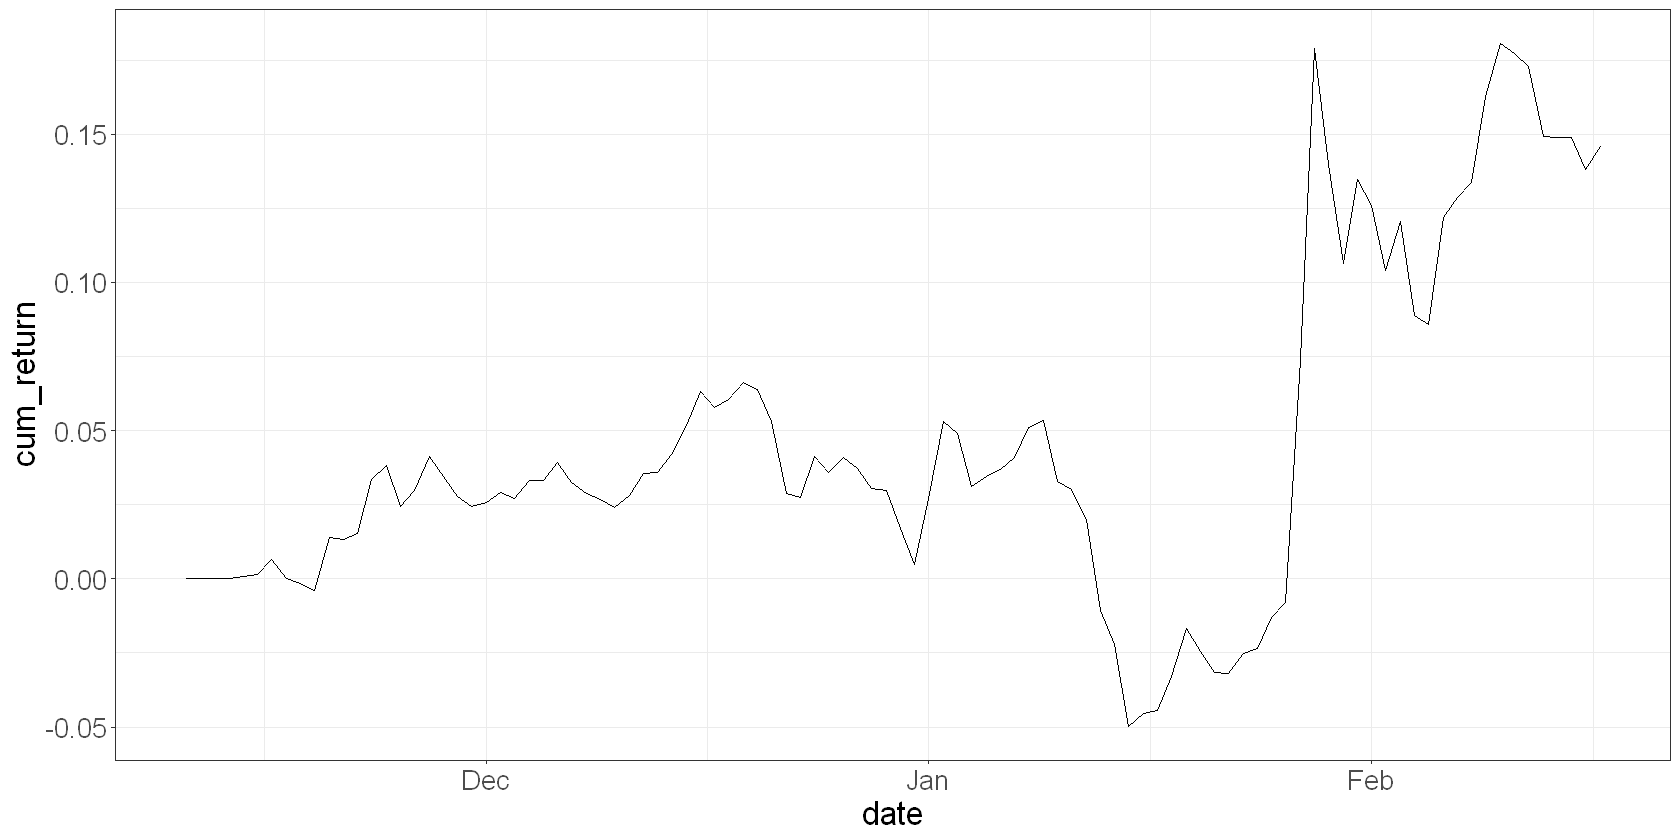

In [206]:
weights_df %>% 
  left_join(strategy_df, by = c("ticker", "date")) %>% 
  mutate(strat_return = weight * total_fwd_return_simple) %>% 
  replace_na(list(strat_return = 0)) %>% 
  group_by(date) %>% 
  summarise(port_return = sum(strat_return), .groups = "drop") %>% 
  mutate(port_return_log = log(1 + port_return)) %>% 
  mutate(cum_return = cumsum(port_return_log)) %>% 
  ggplot(aes(x = date, y = cum_return)) + geom_line()

[1] "2021-02-18"

In [201]:
exp_returns_wide %>% head

date,ADAUSDT,ALGOUSDT,ATOMUSDT,AVAXUSDT,BANDUSDT,BATUSDT,BCHUSDT,BLZUSDT,BNBUSDT,⋯,ARKUSDT,BIGTIMEUSDT,GASUSDT,POWRUSDT,TIAUSDT,MEMEUSDT,ORDIUSDT,1000BONKUSDT,PYTHUSDT,1000SATSUSDT
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020-11-10,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2020-11-11,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2020-11-12,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2020-11-13,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2020-11-14,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2020-11-15,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [162]:
weights_df %>% 
  left_join(strategy_df, by = c("ticker", "date")) %>% 
  mutate(strat_return = weight * total_fwd_return_simple) %>% 
  replace_na(list(strat_return = 0)) %>% 
  group_by(date) %>% 
  summarise(port_return = sum(strat_return), .groups = "drop") %>% 
  filter(abs(port_return) > 0.0001)

date,port_return
<date>,<dbl>
2021-02-22,-0.0020396386
2021-02-23,0.0034974428
2021-02-24,0.0053171001
2021-02-25,0.0018109421
2021-02-26,0.0171056292
2021-02-27,0.0050864032
2021-02-28,0.0040944290
2021-03-01,0.0010111482
2021-03-02,-0.0011006109


In [97]:
length(exp_rets)
ncol(full_covmat)

[1] 154

[1] 154

In [92]:
# universe_tickers - put everything in this order

In [76]:
current_tickers <- colnames(today_covmat_shrunk)
current_tickers

[1] "ADAUSDT"   "ALGOUSDT"  "ATOMUSDT"  "BANDUSDT"  "BATUSDT"   "BCHUSDT"  
 [7] "BNBUSDT"   "BTCUSDT"   "COMPUSDT"  "DASHUSDT"  "DOGEUSDT"  "DOTUSDT"  
[13] "EOSUSDT"   "ETCUSDT"   "ETHUSDT"   "IOSTUSDT"  "IOTAUSDT"  "KAVAUSDT" 
[19] "KNCUSDT"   "LINKUSDT"  "LTCUSDT"   "MKRUSDT"   "NEOUSDT"   "OMGUSDT"  
[25] "ONTUSDT"   "QTUMUSDT"  "RLCUSDT"   "SNXUSDT"   "SXPUSDT"   "THETAUSDT"
[31] "TRXUSDT"   "VETUSDT"   "WAVESUSDT" "XLMUSDT"   "XMRUSDT"   "XRPUSDT"  
[37] "XTZUSDT"   "ZECUSDT"   "ZILUSDT"   "ZRXUSDT"

In [77]:
full_covmat <- matrix(0, nrow = length(universe_tickers), ncol = length(universe_tickers),
         dimnames = list(universe_tickers, universe_tickers))
full_covmat[current_tickers, current_tickers] <- today_covmat_shrunk
full_covmat

ERROR: Error in full_covmat[current_tickers, current_tickers] <- today_covmat_shrunk: number of items to replace is not a multiple of replacement length


In [81]:
length(full_covmat[current_tickers, current_tickers]) 
length(today_covmat_shrunk)

[1] 1600

[1] 1600

In [82]:
# Assuming current_assets is correctly ordered to match current_cov_matrix
print(dim(today_covmat_shrunk))  # Should print 40 40 (or another square matrix size)
print(all(rownames(today_covmat_shrunk) == current_tickers))  # Should be TRUE
print(all(colnames(today_covmat_shrunk) == current_tickers)) 

[1] 40 40
[1] TRUE
[1] TRUE


In [94]:
# Assuming 'all_assets' contains all tickers in the order used by 'full_cov_matrix'
current_assets_ordered <- intersect(universe_tickers, rownames(today_covmat_shrunk))

# Ensure 'current_cov_matrix' is reordered correctly
today_covmat_shrunk_reordered <- today_covmat_shrunk[current_assets_ordered, current_assets_ordered] %>% as.matrix()
full_covmat <- full_covmat[universe_tickers, universe_tickers]

# Then, replace in 'full_cov_matrix'
full_covmat[current_assets_ordered, current_assets_ordered] <- today_covmat_shrunk_reordered

# replace zeros on diagonal with average variance
# Identify zeros on the diagonal
zero_diag_indices <- which(diag(full_covmat) == 0)

# Replace these zeros with the average variance
diag(full_covmat)[zero_diag_indices] <- average_variance

In [95]:
is.positive.semi.definite(full_covmat, tol=1e-8)
isSymmetric(full_covmat)

[1] TRUE

[1] TRUE